In [1]:
import pickle
from sklearn.model_selection import train_test_split
import sys
from MusicGenreClassificationRegularization import *
from Supplements import *

In [2]:
from z3 import *


class Optimizer:
    """
    This is a general purpose Optimization with a MaxSAT approach that takes into account multiple margins and tries
    to satisfy the strict constraints on a decision point first.

    W: parameters to learn
    T: Boolean variables for training instances. One training instance has M T variables. M is the number of margins.
       For each instance, first constraint is the most lenient and the last constraint is the most strict.
    Soft Constraints: Constraints based on training instances. For each instance there is one constraint.
    Hard Constraints: By default constraint the definitions of each constraint in T. Specific knowledge constraints
                      are also added for specific use cases

    Optimization function is the main MaxSAT algorithm.
    """

    def __init__(self, verbose=False):
        self.solver = SolverFor('NRA')
        self.W = None
        self.T = None
        self.Soft_Constraints = []
        self.Hard_Constraints = []
        self.relaxation = None
        self.out = None
        self.solver.set('timeout',  10000)
        set_option('smt.random_seed', random.randint(0, 1000))

        if verbose:
            set_option('verbose', 10)

        set_param('smt.arith.solver', 2)

    def reset(self):
        self.solver.reset()
        self.W = None
        self.T = None
        self.Soft_Constraints = []
        self.Hard_Constraints = []
        self.relaxation = None
        self.out = None

    @staticmethod
    def GetLhsRhs(c):
        split = c.split(' >=')
        return split[0], split[1][-1]

    @staticmethod
    def GetClauseNum(c):
        return int(c.split(',')[0].split('__')[1])

    def OptimizationFuMalik(self, length=None):
        print('starting the check')
        self.solver.add(self.Hard_Constraints)
        if length is None:
            print('please provide the total number of margins')
            sys.exit(0)
        i = 0
        Fs = self.Soft_Constraints.copy()
        while True:
            out = self.solver.check(Fs)
            if out == sat:
                print('found sat')
                self.out = sat
                break
            elif out == unknown:
                print('found unknown')
                self.out = unknown
                break
            else:
                print('found unsat')
                relaxed_variables = []
                core = self.solver.unsat_core()
                print('size of core:', len(core))
                for c in core:
                    i += 1
                    Fs.remove(c)
                    Fs.append(Or(c, Bool('r_' + str(i))))
                if len(relaxed_variables) > 0:
                    self.solver.add(Sum([If(r, 1, 0) for r in relaxed_variables]) == self.relaxation)
                if len(core) == 0:
                    print('no solution is possible')
                    self.out = unsat
                    break


In [67]:
from Optimizer import Optimizer
from z3 import *
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import statistics


class LinearClassificationMultiClassLearner(Optimizer):
    """
    MultiClass Linear Classification happens in this class.
    Inherits the optimizer class where the magic happens
    """

    def __init__(self, verbose=False):
        super().__init__(verbose)
        self.runtime = 0
        self.W_learnt = None
        self.highest_degree = None
        self.instances_to_change = []
        self.training_accuracies = []
        self.training_losses = []
        self.all_weights = []
        self.targets = []
        self.validation_losses = []

    @staticmethod
    def sumproduct(X, W):
        out = W[0]
        for i in range(len(X)):
            out = out + X[i] * W[i + 1]
        return out

    def add_knowledge_constraints(self, X, y, K=None):
        pass

    def add_decision_constraints(self, X, y, M=None, learner='maxl'):
        Fs = []
        Fh = []

        for i in range(len(self.targets)):
            print('i =', i)
            y_label = [1 if x == self.targets[i] else 0 for x in y]
            print(self.W[i])
            for j in range(X.shape[0]):
                if y_label[j] == 1:
                    for k in range(len(M)):
                        Fh.append(
                                self.T[X.shape[0] * i * len(M) + j * len(M) + k] ==
                                (LinearClassificationMultiClassLearner.sumproduct(list(X.iloc[j]), self.W[i]) > M[k]))
                        Fs.append(self.T[X.shape[0] * i * len(M) + j * len(M) + k])
                else:
                    for k in range(len(M)):
                        Fh.append(
                            self.T[X.shape[0] * i * len(M) + j * len(M) + k] ==
                            (LinearClassificationMultiClassLearner.sumproduct(list(X.iloc[j]), self.W[i]) < -M[k]))
                        Fs.append(self.T[X.shape[0] * i * len(M) + j * len(M) + k])

        self.Soft_Constraints.extend(Fs)
        self.Hard_Constraints.extend(Fh)

    def add_weight_constraints(self, low=-1000, high=1000):
        Fh = []
        for W in self.W:
            for w in W:
                Fh.append(And(w >= low, w <= high))
        self.Hard_Constraints.extend(Fh)

    def learn_without_sade(self, X, y, M=None, relaxation=1, K=None, weight_limit=100, learner='maxl'):
        if M is None:
            print('please provide a list of margins')
            sys.exit(0)

        # for classification problems, bigger margin is stricter
        M.sort()
        self.targets = np.unique(y)

        # relaxation variable used in maxsat
        self.relaxation = relaxation

        # parameter initialization
        self.W = [[Real('w_{}_{}'.format(i, j)) for i in range((X.shape[1] + 1))] for j in range(len(np.unique(y)))]
        self.add_weight_constraints(low=-weight_limit, high=weight_limit)

        if K is not None:
            self.add_knowledge_constraints(X, y, K)
            print('knowledge constraints added')

        self.T = BoolVector('t', X.shape[0] * len(M) * len(np.unique(y)))
        self.add_decision_constraints(X, y, M=M, learner=learner)
        start = time.time()
        self.OptimizationFuMalik(length=len(M))
        self.runtime = self.runtime + time.time() - start

        if self.out == sat:
            self.W_learnt = [
                [self.solver.model()[u].numerator_as_long() / self.solver.model()[u].denominator_as_long()
                 for u in w] for w in self.W]
            print('learned parameters')
            print(self.W_learnt)
            training_prediction = self.predict(X, y)
            print('training accuracy:', training_prediction[2])

    def learn(self, X, y, M=None, relaxation=1, K=None, weight_limit=100,
              batch_size=20, epochs=20, maximal_step_size=0.1,
              waiting_period=5, early_stopping=True, test_set=None):

        self.solver.set('timeout', waiting_period * 1000)
        early_stopping = early_stopping
        if M is None:
            print('please provide a list of margins')
            sys.exit(0)

        # for classification problems, bigger margin is stricter
        M.sort()
        self.targets = np.unique(y)

        # relaxation variable used in maxsat
        self.relaxation = relaxation

        # parameter initialization
        self.W = [[Real('w_{}_{}'.format(i, j)) for i in range((X.shape[1] + 1))] for j in range(len(np.unique(y)))]
        print(self.W)

        all_indices = list(range(X.shape[0]))
        all_batches = [all_indices[i * batch_size: (i + 1) * batch_size]
                       for i in range(int(len(all_indices) / batch_size))]
        current_weights = []
        gradient_direction = []
        stop_learning = False
        for ep in range(epochs):
            if stop_learning:
                break
            for j in range(len(all_batches)):
                if (len(self.training_losses) + 1) % 50 == 0:
                    print('\n\n iteration: {} \n\n'.format(len(self.training_losses) + 1))
                active_indices = all_batches[j]
                print('number of instances being considered:', len(active_indices))
                if K is not None:
                    self.add_knowledge_constraints(X, y, K)
                    print('knowledge constraints added')

                self.add_weight_constraints(low=-weight_limit, high=weight_limit)

                if len(current_weights) > 0:
                    print(gradient_direction)
                    self.Hard_Constraints.append(
                        And([And([If(current_weights[i][k] == -weight_limit, self.W[i][k] > current_weights[i][k],
                                     And(self.W[i][k] < current_weights[i][k], self.W[i][k] >= current_weights[i][k] -
                                         maximal_step_size)) if gradient_direction[i][k] == 1
                                  else If(current_weights[i][k] == weight_limit, self.W[i][k] < current_weights[i][k],
                                          And(self.W[i][k] > current_weights[i][k], self.W[i][k] <=
                                              current_weights[i][k] + maximal_step_size))
                                  for k in range(len(self.W[i]))]) for i in range(len(self.W))]))

                self.T = BoolVector('t', X.shape[0] * len(M) * len(np.unique(y)))
                X_sub = X.iloc[active_indices, :]
                y_sub = [y[i] for i in active_indices]
                X_sub.reset_index(drop=True, inplace=True)
                self.add_decision_constraints(X_sub, y_sub, M=M)

                # optimization step (maxsat)
                start = time.time()
                self.OptimizationFuMalik(length=len(M))
                self.runtime = self.runtime + time.time() - start

                print('runtime:', self.runtime)

                if self.out == sat:
                    self.W_learnt = [
                        [self.solver.model()[u].numerator_as_long() / self.solver.model()[u].denominator_as_long()
                         for u in w] for w in self.W]
                    print('learned parameters')
                    print(self.W_learnt)
                    self.all_weights.append(self.W_learnt)
                    gradient_all = self.calculate_gradient(X, y)
                    gradient_values = gradient_all[0]
                    self.training_losses.append(gradient_all[1])
                    if test_set is not None:
                        self.validation_losses.append(self.calculate_gradient(test_set[0], test_set[1])[1])
                    gradient_direction = [[1 if g >= 0 else -1 for g in G] for G in gradient_values]
                    print('gradient:', gradient_values)
                    current_weights = self.W_learnt.copy()
                    training_prediction = self.predict(X, y)
                    print('training accuracy:', training_prediction[2], self.training_losses[-1])
                else:
                    print('found unknown. randomizing gradients, moving to the next batch')
                    gradient_direction = [[g * -1 for g in G] for G in gradient_direction]

                self.Soft_Constraints = []
                self.Hard_Constraints = []
                self.T = None
                self.W_learnt = None
                self.out = None
                self.solver.reset()

                if early_stopping:
                    if test_set is not None:
                        if len(self.validation_losses) >= 400 and len(self.validation_losses) % 100 == 0:
                            avg_loss_last_50 = statistics.mean(self.validation_losses[-200:])
                            avg_loss_last_100_50 = statistics.mean(self.validation_losses[-400:-200])
                            if (avg_loss_last_100_50 - avg_loss_last_50) / avg_loss_last_100_50 <= 0.02:
                                print('stopping the iterations as there is no improvement')
                                stop_learning = True  
                    else:
                        if len(self.training_losses) >= 400 and len(self.training_losses) % 100 == 0:
                            avg_loss_last_50 = statistics.mean(self.training_losses[-200:])
                            avg_loss_last_100_50 = statistics.mean(self.training_losses[-400:-200])
                            if (avg_loss_last_100_50 - avg_loss_last_50) / avg_loss_last_100_50 <= 0.02:
                                print('stopping the iterations as there is no improvement')
                                stop_learning = True
                if stop_learning:
                    break

        self.W_learnt = current_weights
        print('all training accuracies:', self.training_accuracies)
        print('all training loss:', self.training_losses)
        if test_set is not None:
            print('all validation loss:', self.validation_losses)
            self.W_learnt = self.all_weights[self.validation_losses.index(min(self.validation_losses))]
        else:
            self.W_learnt = self.all_weights[self.training_losses.index(min(self.training_losses))]

    def predict(self, X, y):
        weights = self.W_learnt
        indices = list(range(X.shape[0]))

        X_1 = X.copy()
        X_1.insert(loc=0, column='intercept', value=[1] * X.shape[0])
        X_1 = X_1[:].values

        confidence = [list(X_1.dot(pd.Series(weights[i]))) for i in range(len(self.targets))]
        predictions = [[confidence[j][i] for j in range(len(np.unique(y)))] for i in range(X.shape[0])]
        predictions = [np.unique(y)[p.index(max(p))] for p in predictions]
        predictions_correct = [1 if y[i] == predictions[i] else 0 for i in range(len(predictions))]

        return predictions, sum(predictions_correct), sum(predictions_correct) / len(predictions_correct), confidence

    def calculate_gradient(self, X, y):
        gradient = []
        loss = []
        self.instances_to_change = []
        if len(self.instances_to_change) > 0:
            X_val = X
            y_val = y.copy()
            for i in self.instances_to_change:
                if y[i] == 0:
                    y_val[i] = 1
                else:
                    y_val[i] = 0
        else:
            X_val = X
            y_val = y

        H = self.predict(X_val, y_val)[3]

        for i in range(len(self.targets)):
            g = []
            h = H[i]
            y_label = [1 if x == self.targets[i] else 0 for x in y]

            Z = [1 / (1 + np.exp(-h[j])) for j in range(len(y_val))]
            L = log_loss(y_label, Z)
            Z_Y = [Z[j] - y_label[j] for j in range(len(y_val))]

            g.append(sum(Z_Y))
            g.extend(list(X_val.T.dot(Z_Y)))
            g = [gr / X_val.shape[0] for gr in g]
            gradient.append(g)
            loss.append(L)

        return gradient, loss


In [68]:
import sys

import torch


class MusicLinearClassifier(LinearClassificationMultiClassLearner):

    def __init__(self, verbose=False):
        super().__init__(verbose)
        self.alpha = 0

    def add_knowledge_constraints(self, X, y, K=None):
        if K is not None:
            self.alpha = K  # value of k is the value of regularization parameter
            print('Adding hierarchy constraint')
            beatles_index = list(X.columns).index('group_The Beatles')
            X1 = RealVector('x1', X.shape[1])
            print(np.unique(y))
            self.Hard_Constraints.append(ForAll(X1, Implies(And([And(X1[i] <= max(list(X.iloc[:, i])),
                                                                     X1[i] >= min(list(X.iloc[:, i])))
                                                                 for i in range(X.shape[1])] +
                                                                [X1[beatles_index] == 1]),
                                                            And([
                                                                LinearClassificationMultiClassLearner.sumproduct(
                                                                    X1, self.W[0]) < 0,
                                                                LinearClassificationMultiClassLearner.sumproduct(
                                                                    X1, self.W[1]) < 0,
                                                                LinearClassificationMultiClassLearner.sumproduct(
                                                                    X1, self.W[2]) < 0,
                                                                Or(LinearClassificationMultiClassLearner.sumproduct(
                                                                    X1, self.W[3]) > 0,
                                                                   LinearClassificationMultiClassLearner.sumproduct(
                                                                       X1, self.W[4]) > 0
                                                                   )
                                                            ]))))

    def predict(self, X, y):
        weights = self.W_learnt
        X_1 = X.copy()
        X_1.insert(loc=0, column='intercept', value=[1] * X.shape[0])
        X_1 = X_1[:].values

        confidence = [list(X_1.dot(pd.Series(weights[i]))) for i in range(len(self.targets))]
        predictions = [[confidence[j][i] for j in range(len(self.targets))] for i in range(X.shape[0])]
        predictions = [self.targets[p.index(max(p))] for p in predictions]
        predictions_correct = [1 if y[i] == predictions[i] else 0 for i in range(len(predictions))]

        return predictions, sum(predictions_correct), sum(predictions_correct) / len(predictions_correct), confidence

    def calculate_gradient(self, X, y):
        weight_tensors = torch.tensor(self.W_learnt, requires_grad=True)

        X_1 = X.copy()
        X_1.insert(loc=0, column='intercept', value=[1] * X.shape[0])
        X_1 = X_1[:].values
        X_1 = torch.tensor(X_1)
        H = [torch.matmul(X_1, w.double()) for w in weight_tensors]

        y_label = [[1 if x == self.targets[i] else 0 for x in y] for i in range(len(self.targets))]
        Z = [[1 / (1 + torch.exp(-1 * H[i][j])) for j in range(len(H[i]))]
             for i in range(len(self.targets))]

        loss = -sum(
            [sum([torch.log(Z[j][i] + torch.exp(torch.tensor([-10.0]))) if y_label[j][i] == 1
                  else torch.log(1 - Z[j][i] + torch.exp(torch.tensor([-10.0])))
                  for j in range(len(self.targets))])
             for i in range(X.shape[0])]) / X.shape[0] + self.alpha * (
                       1 - sum([torch.max(Z[3][i], Z[4][i]) for i in range(X.shape[0]) if
                                X['group_The Beatles'][i] == 1]) / X[X['group_The Beatles'] == 1].shape[0])

        loss.backward()
        gradients = weight_tensors.grad
        gradients = gradients.detach().cpu().numpy()
        loss = loss.detach().cpu().numpy()
        return gradients, loss.item()


In [99]:
start = time.time()
dataset = 'music_data_24122020.csv'
data = pd.read_csv(dataset, header=0)

data = data.sample(frac=1, random_state=random.randint(1, 1000)).reset_index(drop=True)
instances_to_change = [i for i in range(data.shape[0]) if data['group'][i] == 'The Beatles']
print(len(instances_to_change))
instances_to_change = random.sample(instances_to_change, 60)

for i in instances_to_change:
    data['Music Style'][i] = random.choice(['Metal', 'Electronic', 'Classical'])

X_original = data.iloc[:, :-1]
y = list(data.iloc[:, -1])

categorical_features = [f for f in list(X_original.columns) if f not in set(X_original._get_numeric_data().columns)]
numerical_features = list(set(X_original._get_numeric_data().columns))
scaler = MinMaxScaler()

X_original[numerical_features] = scaler.fit_transform(X_original[numerical_features])
X = pd.get_dummies(X_original, columns=categorical_features, drop_first=False)

162


<ipython-input-99-54b266147db8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Music Style'][i] = random.choice(['Metal', 'Electronic', 'Classical'])


In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

In [162]:
M = [0, 1, 2]
K = 100
epoch = 10
maximal_step_size = 1
batch_size = 5

In [163]:
def single_run(X_train, 
               y_train, 
               test_data=None, 
               M = [0, 1],
               K = 100,
               epoch = 5,
               maximal_step_size = 1,
               batch_size = 5,
               pred_data=None):
    model_sade = MusicLinearClassifier()
    total_runtime = time.time()
    model_sade.learn(X_train, y_train, M=M, K=K, batch_size=batch_size, epochs=epoch, maximal_step_size=maximal_step_size,
                                  waiting_period=5, early_stopping=True, test_set=test_data)
    total_runtime = time.time() - total_runtime
    print('total runtime:', total_runtime)
    test_accuracy = model_sade.predict(pred_data[0], pred_data[1])[2]
    return model_sade.training_losses, model_sade.validation_losses, test_accuracy, model_sade.runtime

In [128]:
from dask.distributed import Client
n_threads = 2
with Client(n_workers=n_threads) as client:
    all_results = client.map(single_run, [X_train, X_train], [y_train, y_train], [None, [X_val, y_val]], [M, M], [K, K], 
                             [epoch, epoch], [maximal_step_size, maximal_step_size], [batch_size, batch_size], [[X_test, y_test], [X_test, y_test]])
    all_results = client.gather(all_results)
    client.close()

In [146]:
all_results[0][2], all_results[1][2]

(0.7185929648241206, 0.6683417085427136)

In [ ]:
random.seed(100)
model_sade_val = MusicLinearClassifier()
total_runtime = time.time()
model_sade_val.learn(X_train, y_train, M=M, K=K,
                     batch_size=batch_size, epochs=epoch,
                     maximal_step_size=maximal_step_size,
                     waiting_period=5, early_stopping=False, 
                     test_set=None)
total_runtime = time.time() - total_runtime

[[w_0_0, w_1_0, w_2_0, w_3_0, w_4_0, w_5_0, w_6_0, w_7_0, w_8_0, w_9_0, w_10_0, w_11_0, w_12_0, w_13_0, w_14_0], [w_0_1, w_1_1, w_2_1, w_3_1, w_4_1, w_5_1, w_6_1, w_7_1, w_8_1, w_9_1, w_10_1, w_11_1, w_12_1, w_13_1, w_14_1], [w_0_2, w_1_2, w_2_2, w_3_2, w_4_2, w_5_2, w_6_2, w_7_2, w_8_2, w_9_2, w_10_2, w_11_2, w_12_2, w_13_2, w_14_2], [w_0_3, w_1_3, w_2_3, w_3_3, w_4_3, w_5_3, w_6_3, w_7_3, w_8_3, w_9_3, w_10_3, w_11_3, w_12_3, w_13_3, w_14_3], [w_0_4, w_1_4, w_2_4, w_3_4, w_4_4, w_5_4, w_6_4, w_7_4, w_8_4, w_9_4, w_10_4, w_11_4, w_12_4, w_13_4, w_14_4]]
number of instances being considered: 5
Adding hierarchy constraint
['Classical' 'Electronic' 'Metal' 'Pop' 'Rock']
knowledge constraints added
i = 0
[w_0_0, w_1_0, w_2_0, w_3_0, w_4_0, w_5_0, w_6_0, w_7_0, w_8_0, w_9_0, w_10_0, w_11_0, w_12_0, w_13_0, w_14_0]
i = 1
[w_0_1, w_1_1, w_2_1, w_3_1, w_4_1, w_5_1, w_6_1, w_7_1, w_8_1, w_9_1, w_10_1, w_11_1, w_12_1, w_13_1, w_14_1]
i = 2
[w_0_2, w_1_2, w_2_2, w_3_2, w_4_2, w_5_2, w_6_2, w_7_2

In [152]:
total_runtime, model_sade_val.runtime

(2399.409191131592, 1956.1487257480621)

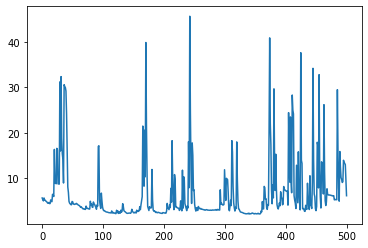

In [155]:
import matplotlib.pyplot as plt
plt.plot(model_sade_val.training_losses)

In [161]:
model_sade_val.predict(X_test, y_test)[2]

0.6934673366834171